In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/음성인식_프로젝트

/content/drive/MyDrive/음성인식_프로젝트


# 프로젝트 소개
+ 음성 데이터를 7가지 감정으로 분류하여 분석하는 프로젝트
+ 참고 모델 링크: https://github.com/HanNayeoniee/Trauma-Detector
+ 참고 데이터 링크: https://aihub.or.kr/aihubdata/data/view.do?currMenu=120&topMenu=100&dataSetSn=263&aihubDataSe=extrldata
    + 5차년도_2차 데이터 중에서 5000개 정도의 데이터만 사용하여 'input_emotion' 폴더에 저장


# 데이터 로드 및 전처리

+ **분석에 사용한 데이터 다운로드 링크**: **https://drive.google.com/drive/folders/1eP4QS2YJ_MtLbqtGX-GcXsmskY-QtBBV?usp=drive_link**
   + (용량 문제로 음성 데이터는 제외하고 spectrogram으로 변환한 데이터부터 넣었습니다.)

## STFT 수행하여 spectrogram 생성
+ 7가지 감정으로 분류된 wav 데이터들을 로드하여 STFT를 통해 spectrogram 생성
    + 2s 길이의 데이터를 sampling rate=1024로 설정해 FFT 수행 -> 샘플 512개 만큼 overlap하며 shift -> 모든 데이터가 0~1 사이의 값을 가지도록 min-max scaler를 사용해 스케일링

```
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
import os
import librosa

# 감정 폴더 경로
emotion_folder = 'input_emotion'

# 저장할 폴더 경로
save_folder = 'spectrogram_output'

# 음성 데이터를 로드하는 함수
def load_audio(file_path):
    audio, sampling_rate = librosa.load(file_path, sr=None)  # 파일 경로와 샘플링 주파수 설정
    return audio, sampling_rate

# 음성 데이터를 STFT를 통해 spectrogram으로 변환하는 함수
def create_spectrogram(audio, sampling_rate, window_size=2, overlap=0.5):
    # 2s 길이의 데이터로 자르기
    num_samples = int(2 * sampling_rate)
    audio = audio[:num_samples]

    # STFT 파라미터 설정
    nperseg = 512
    noverlap = int(nperseg * overlap)

    # STFT 수행
    _, _, spec = signal.stft(audio, fs=sampling_rate, window='hann', nperseg=nperseg, noverlap=noverlap)

    # Spectrogram의 절댓값 계산
    spec = np.abs(spec)

    # Spectrogram을 0~1 사이 값으로 스케일링
    spec = minmax_scale(spec, axis=1)

    return spec

# 폴더가 존재하지 않을 경우 폴더 생성
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# 각각의 감정 폴더에 있는 WAV 파일들을 처리
for emotion in os.listdir(emotion_folder):
    emotion_path = os.path.join(emotion_folder, emotion)
    if os.path.isdir(emotion_path):
        for file_name in os.listdir(emotion_path):
            file_path = os.path.join(emotion_path, file_name)

            # WAV 파일 로드
            audio, sampling_rate = load_audio(file_path)

            # STFT를 통해 spectrogram 생성
            spectrogram = create_spectrogram(audio, sampling_rate)

            # 생성된 spectrogram을 이미지 파일로 저장
            save_path = os.path.join(save_folder, f'{emotion}_{file_name[:-4]}.png')
            plt.imshow(spectrogram, aspect='auto', cmap='jet')
            plt.colorbar()
            plt.xlabel('Time')
            plt.ylabel('Frequency')
            plt.title('Spectrogram')
            plt.savefig(save_path)
            plt.close()

            # 저장 완료 메시지 출력
            print(f'Saved spectrogram: {save_path}')
```

## 데이터 분할

In [ ]:
import os
import shutil

# 입력 폴더와 출력 폴더 경로 설정
input_folder = 'spectrogram_output'  # 이미지 파일이 저장된 폴더 경로
output_folder = 'output'  # 분류된 데이터셋이 저장될 폴더 경로

# 출력 폴더 생성
os.makedirs(output_folder, exist_ok=True)

# 파일 분류
for file in os.listdir(input_folder):
    if file.endswith('.png'):
        file_path = os.path.join(input_folder, file)
        class_name = file.split('_')[0]

        if class_name.startswith('happiness') or class_name.startswith('neutral'):
            class_folder = os.path.join(output_folder, '0')
        else:
            class_folder = os.path.join(output_folder, '1')

        os.makedirs(class_folder, exist_ok=True)
        dest_path = os.path.join(class_folder, file)
        shutil.copyfile(file_path, dest_path)

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import shutil
import splitfolders

# 경로와 파일명 설정
output_folder = 'output/'
dataset_folder = 'output_dataset/'

# Perform the data split
splitfolders.ratio(output_folder, output=dataset_folder, seed=42, ratio=(0.7, 0.2, 0.1))

Copying files: 4784 files [01:49, 43.54 files/s] 


# 모델 생성

## VGG
+ Visual Geometry Group
+ 레이어 수의 따라 VGG-13, VGG-16, VGG-19 등으로 구분
+ 커널 사이즈를 3 x 3으로 고정하여, 더 많은 ReLU함수를 사용하고, 더 많은 비선형성 확보

<img src='https://royalsocietypublishing.org/cms/asset/0061128d-7436-4b1d-a7d8-2c2505b56498/rspa20190662f10.jpg' width="800" height ="" /><br>

In [ ]:
# gpu 사용 가능한지 확인
# 사용 가능하다면 device_type에 CPU, GPU 2개가 뜸

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12926164760177041324
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14328594432
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2177082759258510529
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
import os
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt


from tensorflow.keras import Input
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight

## 모델 레이어 쌓기
+ VGG-13

In [ ]:
input_tensor = Input(shape=(288,432,3), dtype='float32', name='input')

x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(input_tensor)
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(4096, kernel_initializer='he_normal')(x)
x = Dense(1024, kernel_initializer='he_normal')(x)
x = Dense(100, kernel_initializer='he_normal')(x)

output_tensor = Dense(1, activation='sigmoid')(x)

vgg13 = Model(input_tensor, output_tensor)
vgg13.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 288, 432, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 288, 432, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 288, 432, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 144, 216, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 144, 216, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 144, 216, 128)     147584    
                                                             

+ VGG-16

In [ ]:
input_tensor = Input(shape=(288,432,3), dtype='float32', name='input')
# input_tensor = Input(shape=(244,244,3), dtype='float32', name='input')

x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(input_tensor)
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(4096, kernel_initializer='he_normal')(x)
x = Dense(1024, kernel_initializer='he_normal')(x)
x = Dense(100, kernel_initializer='he_normal')(x)

output_tensor = layers.Dense(1, activation='sigmoid')(x)

vgg16 = Model(input_tensor, output_tensor)
vgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 288, 432, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 288, 432, 64)      1792      
                                                                 
 conv2d_11 (Conv2D)          (None, 288, 432, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 144, 216, 64)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 144, 216, 128)     73856     
                                                                 
 conv2d_13 (Conv2D)          (None, 144, 216, 128)     147584    
                                                           

+ VGG-19

In [ ]:
input_tensor = Input(shape=(288,432,3), dtype='float32', name='input')
# input_tensor = Input(shape=(244,244,3), dtype='float32', name='input')

x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(input_tensor)
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(4096, kernel_initializer='he_normal')(x)
x = Dense(1024, kernel_initializer='he_normal')(x)
x = Dense(100, kernel_initializer='he_normal')(x)

output_tensor = layers.Dense(1, activation='sigmoid')(x)

vgg19 = Model(input_tensor, output_tensor)
vgg19.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 288, 432, 3)]     0         
                                                                 
 conv2d_23 (Conv2D)          (None, 288, 432, 64)      1792      
                                                                 
 conv2d_24 (Conv2D)          (None, 288, 432, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 144, 216, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 144, 216, 128)     73856     
                                                                 
 conv2d_26 (Conv2D)          (None, 144, 216, 128)     147584    
                                                           

## VGG13

### 모델 컴파일, 학습

In [ ]:
BATCHSIZE = 8
EPOCHS = 1

train_dir = 'output_dataset/train'
val_dir = 'output_dataset/val'

# data generator 생성
train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True)  # data augmentation
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(288,432),
                                                    #target_size=(244, 244),
                                                    batch_size=BATCHSIZE,
                                                    class_mode='binary',
                                                    interpolation='bilinear',
                                                    shuffle=True,)

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(val_dir,
                                                    target_size=(288, 432),
                                                    #target_size=(244, 244),
                                                    batch_size=BATCHSIZE,
                                                    class_mode='binary',
                                                    interpolation='bilinear',
                                                    shuffle=False,)

early_stopping = EarlyStopping(patience=10, monitor='val_loss')

# 체크포인트 콜백 만들기
checkpoint_path='./weights/checkpoint-batch-8-epoch-{epoch:02d}-val_loss-{val_loss:.4f}.hdf5'
checkpoint=ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_weights_only=True)


vgg13.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

print("steps_per_epoch: ", len(train_generator))
print("validation_steps: ", len(valid_generator))
history = vgg13.fit_generator(train_generator,
                                epochs=EPOCHS,
                                steps_per_epoch=len(train_generator),
                                validation_data=valid_generator,
                                validation_steps=len(valid_generator),
                                verbose=1,
                                callbacks=[early_stopping, checkpoint])

Found 3347 images belonging to 2 classes.
Found 956 images belonging to 2 classes.


steps_per_epoch:  419
validation_steps:  120


<ipython-input-20-204ec75bf2cf>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = vgg13.fit_generator(train_generator,


419/419 [==============================] - ETA: 0s - loss: 0.7183 - acc: 0.5978
Epoch 1: saving model to ./weights/checkpoint-batch-8-epoch-01-val_loss-0.6740.hdf5
419/419 [==============================] - 464s 1s/step - loss: 0.7183 - acc: 0.5978 - val_loss: 0.6740 - val_acc: 0.6025


+ 시각화

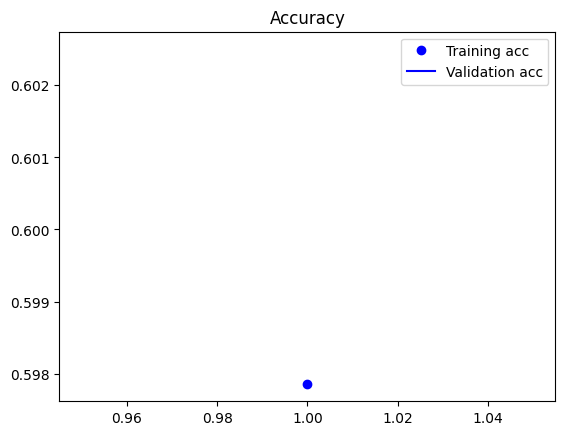

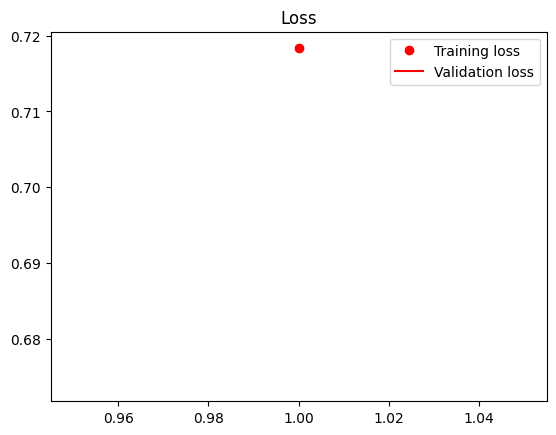

In [ ]:
# 그래프 그리기
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()

plt.show()

### 모델 성능 평가

In [ ]:
BATCHSIZE = 8
EPOCHS = 10

checkpoint_path = 'weights/checkpoint-batch-8-epoch-01-val_loss-0.6740.hdf5'
test_dir='output_dataset/test'
test_datagen = ImageDataGenerator(rescale=1./255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(288, 432),
    batch_size=BATCHSIZE,
    class_mode='binary',
    interpolation='bilinear',
    shuffle=False)

vgg13.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

print("-- Evaluate --")
vgg13.load_weights(checkpoint_path)# Re-evaluate the model
loss, acc = vgg13.evaluate(test_generator, steps= len(test_generator))
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

Found 481 images belonging to 2 classes.


-- Evaluate --
61/61 [==============================] - 55s 899ms/step - loss: 0.6749 - acc: 0.6008
Restored model, accuracy: 60.08%


In [ ]:
checkpoint_path = 'weights/checkpoint-batch-8-epoch-01-val_loss-0.6740.hdf5'
test_dir='output_dataset/test'

test_datagen = ImageDataGenerator(rescale=1./255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(288, 432),
    batch_size=BATCHSIZE,
    class_mode='binary',
    interpolation='bilinear',
    shuffle=False)
vgg13.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])



''' evaluating HTER '''
y_true = test_generator.classes
y_score = vgg13.predict_generator(test_generator, steps = len(test_generator)).ravel()
# Calculate EER threshold
fpr, tpr, threshold = roc_curve(y_true, y_score)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]
# HTER
y_pred = y_score > eer_threshold
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
labels = test_generator.class_indices
print('pred_fake({})  pred_real({})\nactural_fake({})   {:12d}  {:12d}\nactual_real({})   {:12d}  {:12d}\n'.format(labels['0'], labels['1'], labels['0'], tn, fp, labels['1'], fn, tp))

Found 481 images belonging to 2 classes.


<ipython-input-23-0a04b0432de7>:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_score = vgg13.predict_generator(test_generator, steps = len(test_generator)).ravel()


pred_fake(0)  pred_real(1)
actural_fake(0)            192             0
actual_real(1)            289             0



61/61 [==============================] - 7s 118ms/step


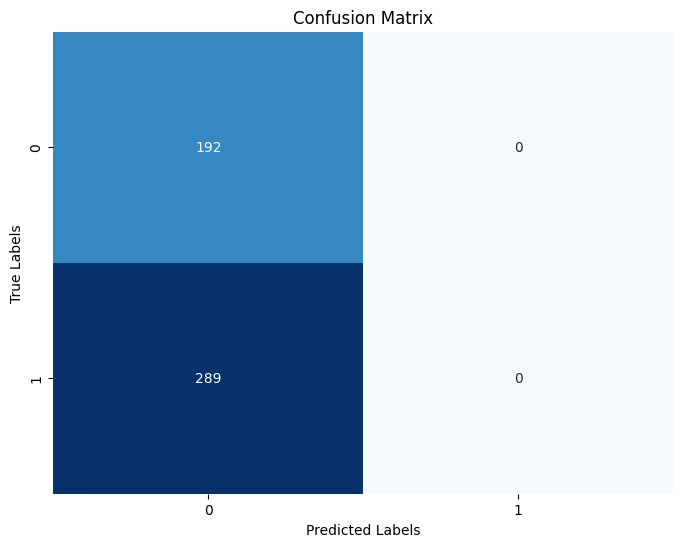

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 테스트 데이터셋 예측값 얻기
y_pred = vgg13.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# 실제값 얻기
y_true = test_generator.classes

# 혼동 행렬 생성
cm = confusion_matrix(y_true, y_pred_classes)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## VGG16

### 모델 컴파일, 학습

In [ ]:
BATCHSIZE = 8
EPOCHS = 1

train_dir = 'output_dataset/train'
val_dir = 'output_dataset/val'

# data generator 생성
train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True)  # data augmentation
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(288,432),
                                                    #target_size=(244, 244),
                                                    batch_size=BATCHSIZE,
                                                    class_mode='binary',
                                                    interpolation='bilinear',
                                                    shuffle=True,)

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(val_dir,
                                                    target_size=(288, 432),
                                                    #target_size=(244, 244),
                                                    batch_size=BATCHSIZE,
                                                    class_mode='binary',
                                                    interpolation='bilinear',
                                                    shuffle=False,)

early_stopping = EarlyStopping(patience=10, monitor='val_loss')

# 체크포인트 콜백 만들기
checkpoint_path='./weights/checkpoint-batch-8-epoch-{epoch:02d}-val_loss-{val_loss:.4f}.hdf5'
checkpoint=ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_weights_only=True)


vgg16.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

print("steps_per_epoch: ", len(train_generator))
print("validation_steps: ", len(valid_generator))
history = vgg16.fit_generator(train_generator,
                                epochs=EPOCHS,
                                steps_per_epoch=len(train_generator),
                                validation_data=valid_generator,
                                validation_steps=len(valid_generator),
                                verbose=1,
                                callbacks=[early_stopping, checkpoint])


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

Found 3347 images belonging to 2 classes.
Found 956 images belonging to 2 classes.


steps_per_epoch:  419
validation_steps:  120


<ipython-input-36-bbf216bfe2bf>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = vgg16.fit_generator(train_generator,


419/419 [==============================] - ETA: 0s - loss: 0.8966 - acc: 0.5978
Epoch 1: saving model to ./weights/checkpoint-batch-8-epoch-01-val_loss-0.6788.hdf5
419/419 [==============================] - 168s 391ms/step - loss: 0.8966 - acc: 0.5978 - val_loss: 0.6788 - val_acc: 0.6025


### 모델 성능 평가

In [ ]:
BATCHSIZE = 8
EPOCHS = 300
checkpoint_path = 'weights/checkpoint-batch-8-epoch-01-val_loss-0.6788.hdf5'
test_dir='output_dataset/test'
test_datagen = ImageDataGenerator(rescale=1./255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(288, 432),
    batch_size=BATCHSIZE,
    class_mode='binary',
    interpolation='bilinear',
    shuffle=False)

vgg16.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

print("-- Evaluate --")
vgg16.load_weights(checkpoint_path)# Re-evaluate the model
loss, acc = vgg16.evaluate(test_generator, steps= len(test_generator))
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

Found 481 images belonging to 2 classes.


-- Evaluate --
61/61 [==============================] - 9s 127ms/step - loss: 0.6793 - acc: 0.6008
Restored model, accuracy: 60.08%


In [ ]:
checkpoint_path = 'weights/checkpoint-batch-8-epoch-01-val_loss-0.6788.hdf5'
test_dir='output_dataset/test'

test_datagen = ImageDataGenerator(rescale=1./255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(288, 432),
    batch_size=BATCHSIZE,
    class_mode='binary',
    interpolation='bilinear',
    shuffle=False)
vgg16.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])



''' evaluating HTER '''
y_true = test_generator.classes
y_score = vgg16.predict_generator(test_generator, steps = len(test_generator)).ravel()
# Calculate EER threshold
fpr, tpr, threshold = roc_curve(y_true, y_score)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]
# HTER
y_pred = y_score > eer_threshold
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
labels = test_generator.class_indices
print('pred_fake({})  pred_real({})\nactural_fake({})   {:12d}  {:12d}\nactual_real({})   {:12d}  {:12d}\n'.format(labels['0'], labels['1'], labels['0'], tn, fp, labels['1'], fn, tp))

Found 481 images belonging to 2 classes.


<ipython-input-38-a9935f969313>:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_score = vgg16.predict_generator(test_generator, steps = len(test_generator)).ravel()


pred_fake(0)  pred_real(1)
actural_fake(0)            192             0
actual_real(1)            289             0



## VGG19

### 모델 컴파일, 학습

In [ ]:
BATCHSIZE = 8
EPOCHS = 1

train_dir = 'output_dataset/train'
val_dir = 'output_dataset/val'

# data generator 생성
train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True)  # data augmentation
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(288,432),
                                                    #target_size=(244, 244),
                                                    batch_size=BATCHSIZE,
                                                    class_mode='binary',
                                                    interpolation='bilinear',
                                                    shuffle=True,)

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(val_dir,
                                                    target_size=(288, 432),
                                                    #target_size=(244, 244),
                                                    batch_size=BATCHSIZE,
                                                    class_mode='binary',
                                                    interpolation='bilinear',
                                                    shuffle=False,)

early_stopping = EarlyStopping(patience=10, monitor='val_loss')

# 체크포인트 콜백 만들기
checkpoint_path='./weights/checkpoint-batch-8-epoch-{epoch:02d}-val_loss-{val_loss:.4f}.hdf5'
checkpoint=ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_weights_only=True)


vgg19.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

print("steps_per_epoch: ", len(train_generator))
print("validation_steps: ", len(valid_generator))
history = vgg19.fit_generator(train_generator,
                                epochs=EPOCHS,
                                steps_per_epoch=len(train_generator),
                                validation_data=valid_generator,
                                validation_steps=len(valid_generator),
                                verbose=1,
                                callbacks=[early_stopping, checkpoint])

Found 3347 images belonging to 2 classes.
Found 956 images belonging to 2 classes.


steps_per_epoch:  419
validation_steps:  120


<ipython-input-31-639e7d9736e1>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = vgg19.fit_generator(train_generator,


419/419 [==============================] - ETA: 0s - loss: 8750279.0000 - acc: 0.5503
Epoch 1: saving model to ./weights/checkpoint-batch-8-epoch-01-val_loss-7.4350.hdf5
419/419 [==============================] - 211s 491ms/step - loss: 8750279.0000 - acc: 0.5503 - val_loss: 7.4350 - val_acc: 0.6025


### 모델 성능 평가

In [ ]:
ATCHSIZE = 8
EPOCHS = 300
checkpoint_path = 'weights/checkpoint-batch-8-epoch-01-val_loss-7.4350.hdf5'
test_dir='output_dataset/test'
test_datagen = ImageDataGenerator(rescale=1./255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(288, 432),
    batch_size=BATCHSIZE,
    class_mode='binary',
    interpolation='bilinear',
    shuffle=False)

vgg19.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

print("-- Evaluate --")
vgg19.load_weights(checkpoint_path)# Re-evaluate the model
loss, acc = vgg19.evaluate(test_generator, steps= len(test_generator))
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

Found 481 images belonging to 2 classes.


-- Evaluate --
61/61 [==============================] - 10s 147ms/step - loss: 7.4353 - acc: 0.6008
Restored model, accuracy: 60.08%
